In [1]:
%load_ext watermark
%watermark -a "Ernesto Carro" -u -d -v -p numpy,scipy,matplotlib,torch,sklearn 

Ernesto Carro 
last updated: 2019-02-09 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
matplotlib 3.0.2
torch 1.0.0
sklearn 0.20.1


# Clasificación de galaxias

El objetivo de esta tarea es hacer una red neuronal que pueda diferenciar entre tres tipos de galaxia: espiral, irregular y elíptica. Se va a hacer por medio de una red convolucional (para disminuír el número de parámetros de la red.

El ejercicio está basado en el [tutorial](https://www.tensorflow.org/tutorials/layers) de tensorflow para capas en una red convolutiva.

Las fotos de estas galaxias las necesitan sacar del folder zip que se llame 'source' (basta con darle click derecho y luego descomprimir, en realidad.

Primero lo primero, cargar las bibliotecas necesarias. Recuerden, si una les aparece que no está instalada, basta con que utilicen el ambiente virtual para instalar cosas. En particular, tensorflow y PIL (cuyo paquete se llama Pillow, es decir, `pip install pillow`).

In [93]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image
import os
import zipfile
import io
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import TensorDataset, DataLoader, Dataset

Ahora vamos a cargar en RAM todas las fotos. Para ello primero cargamos los nombres y sus tipos (lo único que nos interesa). Me aprovecho de ello para de una vez guardar en un data frame sólo las columnas de interés. No sólo eso pero de una vez vamos a convertir las etiquetas en las tres posibilidades de galaxia que nos interesa clasificar: Elíptica ()

In [94]:
data = pd.read_csv('EFIGI_data.txt', sep=",")

Podemos ver aquí los primeros 5 renglones de este dataframe

In [95]:
data.head()

,PhotoName,HStage,Type,NType
0,PGC0009530,10,I,2
1,PGC0025524,-5,E,0
2,PGC0002149,-3,S,1
3,PGC0004363,-3,S,1
4,PGC0004540,6,S,1


Esperemos tener una distribución masomenos equitativa de cada galaxia. Usando `groupby` podremos verificar esto

In [96]:
data.groupby("Type").count()

,PhotoName,HStage,NType
Type,,,
E,200,200,200
I,200,200,200
S,200,200,200


Pues... Resulta que no. En fin, A la mejor el problema fue dar un rango tan grande a las espirales

In [97]:
data.groupby("HStage").count().Type

HStage
-6      14
-5     163
-4      23
-3      18
-2      14
-1       7
 0       6
 1      19
 2      14
 3      18
 4      14
 5       8
 6      31
 7      15
 8      27
 9       9
 10    156
 11     44
Name: Type, dtype: int64

Si pues, un poco más homogeneo... Tenemos aún que cargar 82MB de imágenes en RAM. Esto puede ser un grave problema.

In [98]:
images = []
def ProcImage(row):
    archive = zipfile.ZipFile('source.zip', 'r')
    img_data = archive.read(os.path.join('source',row.PhotoName+'.png'))
    bytes_io = io.BytesIO(img_data)
    return Image.open(bytes_io).convert('L')
images = data.apply(lambda row: ProcImage(row), axis = 1)
shape = [images[0].height, images[0].width]
# To normalized numpy array
images = np.array(
    list(map(lambda pic: np.reshape(np.array(pic), [1, pic.width * pic.height])[0] , images)), dtype = 'float32'
) / 255
images.shape

(600, 65025)

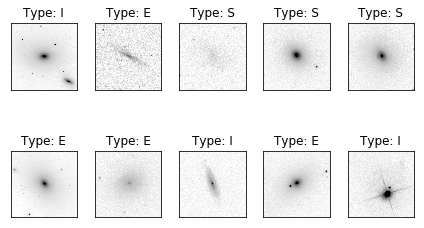

In [99]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5,
        sharex=True, sharey=True)
ax = ax.flatten()
to_selec = np.random.randint(600, size = 10)
for i in range(10):
    img = images[to_selec[i]].reshape(255, 255)
    ax[i].imshow(img, cmap='Greys')
    ax[i].set_title('Type: ' + data.iloc[i].Type)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Dividimos los datos en tres partes,

In [113]:
train_data = data.iloc[:400].NType.values
train_images = images[:400]

test_data = data.iloc[400:500].NType.values
test_images = images[400:500]

validation_data = data.iloc[500:].NType.values
validation_images = images[500:]

Para poder comparar nuestra red neuronal, colocaremos como punto de referencia la precisión obtenida al usar el SVM clasificador de sckit-learn.

In [10]:
from sklearn import svm

def svm_baseline():
    clf = svm.SVC(gamma = 'auto')
    clf.fit(train_images, train_data)
    # test
    predictions = [int(a) for a in clf.predict(validation_images)]
    num_correct = sum(int(a == y) for a, y in zip(predictions, validation_data))
    print("Baseline classifier using an SVM.")
    print("%s of %s values correct." % (num_correct, len(validation_data)))
    
svm_baseline()

Baseline classifier using an SVM.
52 of 100 values correct.


Podemos ver que el SVM clasificador tiene una precisión del 52%, record que debemos de romper con nuestra red neuronal.

In [114]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 1, 
          'pin_memory': True}

In [115]:
train_images, train_data = map(
    torch.tensor, (train_images, train_data)
)
train_ds = TensorDataset(train_images, train_data)
train_dl = DataLoader(train_ds, **params)

test_images, test_data = map(
    torch.tensor, (test_images, test_data)
)
test_ds = TensorDataset(test_images, test_data)
test_dl = DataLoader(test_ds, **params)

validation_images, validation_data = map(
    torch.tensor, (validation_images, validation_data)
)
validation_ds = TensorDataset(validation_images, validation_data)
validation_dl = DataLoader(validation_ds, **params)

Definimos nuestra red neuronal convolutiva.

In [116]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 125 * 125, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = x.view(-1, 1, 255, 255)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 3 * 125* 125)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [117]:
from skorch import NeuralNetClassifier

In [118]:
net = NeuralNetClassifier(
    Net,
    max_epochs=50,
    lr=0.01,
    batch_size = 10,
    device=device,
)

In [71]:
from sklearn.model_selection import GridSearchCV


params = {
    'lr': [0.005, 0.01, 0.05, 0.1],
    'batch_size': [5, 10],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(train_images.numpy(), train_data.numpy())
print(gs.best_score_, gs.best_params_)

Re-initializing module because the following parameters were re-set: .
Re-initializing optimizer because the following parameters were re-set: .
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0952       0.3519        1.0929  0.3778
      2        1.0868       0.3519        1.0839  0.3409
      3        1.0731       0.4815        1.0699  0.3343
      4        1.0492       0.5370        1.0411  0.3461
      5        0.9975       0.5926        0.9791  0.3337
      6        0.9090       0.6481        0.8899  0.3326
      7        0.8264       0.6111        0.8355  0.3342
      8        0.7818       0.6296        0.8099  0.3370
      9        0.7501       0.6667        0.7816  0.3405
     10        0.7175       0.6852        0.7622  0.3348
     11        0.6864       0.7222        0.7376  0.3384
     12        0.6556       0.7222        0.7094  0.3399
     13        0.6264       0.7593        0.6824  0.3318


      5        0.8115       0.6852        0.6964  0.3369
      6        0.7793       0.6111        0.7534  0.3350
      7        0.7492       0.6296        0.7532  0.3343
      8        0.7182       0.6852        0.7477  0.3352
      9        0.6936       0.7037        0.7342  0.3333
     10        0.6649       0.7222        0.7166  0.3337
     11        0.6392       0.7222        0.7091  0.3338
     12        0.6150       0.7222        0.7055  0.3337
     13        0.5918       0.7037        0.7062  0.3344
     14        0.5748       0.7037        0.7105  0.3329
     15        0.5524       0.7037        0.7006  0.3331
     16        0.5293       0.6852        0.6970  0.3334
     17        0.5109       0.6852        0.6813  0.3339
     18        0.4956       0.6852        0.6857  0.3353
     19        0.4739       0.6852        0.6995  0.3356
     20        0.4606       0.6852        0.6872  0.3349
     21        0.4443       0.6852        0.6727  0.3342
     22        0.4297       0.6

     17        0.3749       0.8000        0.5905  0.3395
     18        0.3792       0.8000        0.6067  0.3395
     19        0.3642       0.8000        0.5998  0.3396
     20        0.3329       0.8000        0.6154  0.3392
     21        0.3074       0.7818        0.6181  0.3383
     22        0.2837       0.8000        0.6239  0.3395
     23        0.2802       0.7818        0.6198  0.3388
     24        0.2564       0.7818        0.6228  0.3387
     25        0.2432       0.7636        0.6424  0.3398
     26        0.2252       0.7455        0.6507  0.3395
     27        0.2471       0.7455        0.6199  0.3387
     28        0.1918       0.7455        0.6419  0.3466
     29        0.1921       0.7455        0.6534  0.3468
     30        0.2229       0.7636        0.6166  0.3366
     31        0.1827       0.7636        0.6301  0.3359
     32        0.1484       0.7636        0.6744  0.3358
     33        0.1366       0.7455        0.7019  0.3366
     34        0.2202       0.7

     33        1.2248       0.3148        1.2386  0.3339
     34        1.0211       0.7222        1.0592  0.3329
     35        0.4108       0.5926        1.2880  0.3319
     36        0.2500       0.7222        0.6552  0.3316
     37        0.1719       0.6852        0.7814  0.3326
     38        0.1711       0.7593        0.7429  0.3322
     39        0.1578       0.7037        0.7868  0.3321
     40        0.1475       0.7593        0.7996  0.3319
     41        0.1547       0.7222        0.8231  0.3313
     42        0.1375       0.7222        0.8564  0.3319
     43        0.2299       0.3148        2.2362  0.3456
     44        0.7863       0.5556        1.7682  0.3451
     45        0.5312       0.5926        1.3714  0.3385
     46        1.6518       0.3148        1.1517  0.3423
     47        1.1205       0.3148        1.1475  0.3784
     48        1.1198       0.3148        1.1441  0.3376
     49        1.1192       0.3148        1.1409  0.3439
     50        1.1186       0.3

      2        1.1028       0.3519        1.0976  0.3353
      3        1.1024       0.3519        1.0971  0.3451
      4        1.0889       0.3148        2.6250  0.3381
      5        1.1162       0.3519        1.0976  0.3384
      6        1.1024       0.3519        1.0977  0.3377
      7        1.1024       0.3519        1.0978  0.3339
      8        1.1024       0.3519        1.0978  0.3336
      9        1.1024       0.3519        1.0978  0.3340
     10        1.1023       0.3519        1.0978  0.3359
     11        1.1023       0.3519        1.0978  0.3328
     12        1.1022       0.3519        1.0977  0.3356
     13        1.1033       0.3333        1.0997  0.3360
     14        1.1029       0.3519        1.0977  0.3339
     15        1.1021       0.3519        1.0977  0.3356
     16        1.1020       0.3519        1.0978  0.3354
     17        1.1019       0.3519        1.0978  0.3360
     18        1.1018       0.3519        1.0978  0.3349
     19        1.1017       0.3

     34        1.1067       0.3333        1.0991  0.3402
     35        1.1067       0.3333        1.0991  0.3399
     36        1.1067       0.3333        1.0991  0.3393
     37        1.1067       0.3333        1.0991  0.3394
     38        1.1067       0.3333        1.0991  0.3389
     39        1.1067       0.3333        1.0991  0.3404
     40        1.1067       0.3333        1.0991  0.3394
     41        1.1067       0.3333        1.0991  0.3391
     42        1.1066       0.3333        1.0991  0.3397
     43        1.1066       0.3333        1.0991  0.3401
     44        1.1066       0.3333        1.0991  0.3398
     45        1.1066       0.3333        1.0991  0.3400
     46        1.1066       0.3333        1.0991  0.3392
     47        1.1066       0.3333        1.0991  0.3394
     48        1.1066       0.3333        1.0991  0.3396
     49        1.1066       0.3333        1.0991  0.3388
     50        1.1066       0.3333        1.0991  0.3398
Re-initializing module because 

     38        0.6239       0.7636        0.7178  0.2726
     39        0.6086       0.8000        0.7192  0.2716
     40        0.6023       0.7455        0.7290  0.2709
     41        0.6022       0.7636        0.7338  0.2711
     42        0.5913       0.7273        0.7443  0.2709
     43        0.5731       0.7273        0.7561  0.2700
     44        0.5729       0.7273        0.7571  0.2695
     45        0.5591       0.7273        0.7599  0.2698
     46        0.5507       0.6909        0.7880  0.2696
     47        0.5468       0.6909        0.7834  0.2695
     48        0.5324       0.7091        0.7980  0.2694
     49        0.5282       0.7091        0.8063  0.2697
     50        0.5140       0.7273        0.8037  0.2695
Re-initializing module because the following parameters were re-set: .
Re-initializing optimizer because the following parameters were re-set: .
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------


     47        0.0979       0.7593        0.7330  0.2708
     48        0.2628       0.7037        0.6598  0.2703
     49        0.0800       0.7407        0.7206  0.2714
     50        0.0840       0.7222        0.7020  0.2721
Re-initializing module because the following parameters were re-set: .
Re-initializing optimizer because the following parameters were re-set: .
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0947       0.3455        1.0851  0.2752
      2        1.0815       0.3818        1.0667  0.2715
      3        1.0564       0.6364        1.0195  0.2741
      4        0.9952       0.6182        0.9238  0.2752
      5        0.8911       0.6182        0.7941  0.2802
      6        0.7880       0.7091        0.7044  0.2761
      7        0.7290       0.6182        0.7594  0.2780
      8        0.7047       0.7273        0.6184  0.2721
      9        0.6861       0.7455        0.5929  0.2703


      2        1.1002       0.3148        1.1008  0.2779
      3        1.0966       0.3148        1.0970  0.2769
      4        1.0844       0.4259        1.0871  0.2769
      5        1.0451       0.5741        1.0355  0.2780
      6        0.9597       0.6667        0.9460  0.2769
      7        0.8792       0.6111        0.8665  0.2770
      8        0.8313       0.4444        1.0261  0.2769
      9        0.8413       0.7037        0.7834  0.2778
     10        0.7540       0.4444        1.1474  0.2779
     11        0.6901       0.4074        1.4631  0.2740
     12        0.7401       0.6667        0.7969  0.2702
     13        0.7003       0.7037        0.7474  0.2698
     14        0.6360       0.6852        0.7551  0.2697
     15        0.6181       0.6481        0.8659  0.2702
     16        0.5870       0.6111        0.9469  0.2694
     17        0.5131       0.6481        0.6953  0.2698
     18        0.6431       0.7037        0.6764  0.2702
     19        0.5884       0.7

     18        0.5660       0.6852        0.7165  0.2708
     19        0.5351       0.7222        0.7233  0.2696
     20        0.5558       0.7037        0.6962  0.2696
     21        0.5372       0.5926        0.8651  0.2699
     22        0.5468       0.7407        0.6739  0.2697
     23        0.5116       0.6296        0.7763  0.2694
     24        0.6026       0.7037        0.6562  0.2696
     25        0.4740       0.7407        0.6871  0.2700
     26        0.4510       0.7037        0.7448  0.2698
     27        0.4661       0.7593        0.7058  0.2699
     28        0.5484       0.7222        0.6597  0.2698
     29        0.4412       0.5185        0.8377  0.2698
     30        0.5000       0.7222        0.7482  0.2693
     31        0.5155       0.6852        0.8033  0.2694
     32        0.5442       0.7407        0.7656  0.2696
     33        0.4678       0.6111        0.8854  0.2695
     34        0.4233       0.7778        0.8404  0.2702
     35        0.3742       0.7

     44        1.1028       0.3273        1.1014  0.2764
     45        1.1022       0.3273        1.1009  0.2769
     46        1.1020       0.3273        1.1008  0.2703
     47        1.1019       0.3273        1.1007  0.2697
     48        1.1018       0.3273        1.1007  0.2696
     49        1.1018       0.3273        1.1006  0.2698
     50        1.1018       0.3273        1.1006  0.2695
Re-initializing module because the following parameters were re-set: .
Re-initializing optimizer because the following parameters were re-set: .
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1033       0.3333        1.0704  0.2688
      2        1.0716       0.3333        1.1018  0.2702
      3        1.0460       0.4630        1.0409  0.2740
      4        0.9770       0.6296        0.9266  0.2733
      5        0.9279       0.5741        0.8999  0.2759
      6        0.8937       0.3889        1.0419  0.2781


/home/hadas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [119]:
net = NeuralNetClassifier(
    Net,
    max_epochs=50,
    lr=0.005,
    batch_size = 10,
    device=device,
)

net.fit(train_images, train_data)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1026       0.5432        1.0994  0.4464
      2        1.0983       0.5432        1.0953  0.4035
      3        1.0945       0.5556        1.0899  0.4034
      4        1.0893       0.5679        1.0826  0.4009
      5        1.0826       0.5679        1.0737  0.4009
      6        1.0750       0.7037        1.0637  0.4003
      7        1.0663       0.6914        1.0520  0.4004
      8        1.0556       0.5926        1.0370  0.4003
      9        1.0424       0.5926        1.0181  0.4002
     10        1.0259       0.6296        0.9941  0.4013
     11        1.0051       0.7037        0.9636  0.3991
     12        0.9792       0.6914        0.9248  0.4039
     13        0.9482       0.7531        0.8798  0.4029
     14        0.9157       0.7654        0.8334  0.4013
     15        0.8860       0.7407        0.7905  0.3992
     16        0.8629       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Net(
    (conv1): Conv2d(1, 3, kernel_size=(6, 6), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=46875, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=30, bias=True)
    (fc3): Linear(in_features=30, out_features=3, bias=True)
  ),
)

In [120]:
predicted = net.predict(validation_images)
np.mean(predicted == validation_data.numpy())

0.76

In [121]:
predicted = net.predict(test_images)
np.mean(predicted == test_data.numpy())

0.69

Estos son nuestros parámetros de red, usaremos como y la función de costo.

In [122]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [123]:
def test(epoch, model, device, test_loader, best_accuracy, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if best_accuracy <= correct:
        best_accuracy = correct
        best_epoch = epoch
        print('This is the best test accuracy to date.')
    print('The corresonding test accuracy : {}/{}'.format(correct, 
        len(test_loader.dataset)))
    
    return best_accuracy, best_epoch

In [124]:
def validation(model, device, validation_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(validation_loader.dataset)
    print('The corresonding validation accuracy : {}/{}'.format(correct, 
        len(validation_loader.dataset)))
    return correct

In [125]:
def fit(model, params_net, epochs, schedule = False):
    optimizer = optim.SGD(model.parameters(), **params_net)
    best_accuracy = 0
    best_epoch = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                        'max', verbose = True, patience = 20) 
    for epoch in range(1, epochs + 1):
        train(50, model, device, train_dl, optimizer, epoch)
        best_accuracy, best_epoch = test(epoch, model, device, 
                                         test_dl, best_accuracy, best_epoch)
        correct = validation(model,  device, validation_dl)
        
        if schedule:
            scheduler.step(correct)
        
        print('\n')
        
    print("Finished training network.")
    print("Corresponding test accuracy of {}/{} obtained in epoch {}".format(best_accuracy, 
                                                            len(test_dl.dataset), best_epoch))

In [126]:
params_net = {'lr':0.005}
fit(Net().to(device), params_net, 50)

Train Epoch: 1 [0/400 (0%)]	Loss: -0.341280
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 2 [0/400 (0%)]	Loss: -0.333387
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 3 [0/400 (0%)]	Loss: -0.328278
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 4 [0/400 (0%)]	Loss: -0.337588
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 5 [0/400 (0%)]	Loss: -0.322546
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 6 [0/400 (0%)]	Loss: -0.336310
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding

La mejor precisión fue del 80% sobre el conjunto de prueba. Ahora usaremos un algoritmo de actualización de la razón de aprendizaje para mejorar nuestra red.

In [20]:
# params_net = {'lr':0.01, 'momentum':0.1}
# fit(Net().to(device), params_net, schedule= schudle = True)

Usemos una red convolutiva más...

In [21]:
class Net_new(nn.Module):
    def __init__(self):
        super(Net_new, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 6)
        self.fc1 = nn.Linear(6 * 60 * 60, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = x.view(-1, 1, 255, 255)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 60* 60)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [22]:
params_net = {'lr':0.01, 'momentum':0.1}
fit(Net_new().to(device), params_net, 50)

Train Epoch: 1 [0/400 (0%)]	Loss: -0.309058
Train Epoch: 1 [250/400 (62%)]	Loss: -0.333694
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 2 [0/400 (0%)]	Loss: -0.334055
Train Epoch: 2 [250/400 (62%)]	Loss: -0.355570
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 3 [0/400 (0%)]	Loss: -0.355692
Train Epoch: 3 [250/400 (62%)]	Loss: -0.317056
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 4 [0/400 (0%)]	Loss: -0.325824
Train Epoch: 4 [250/400 (62%)]	Loss: -0.349789
This is the best test accuracy to date.
The corresonding test accuracy : 42/100
The corresonding validation accuracy : 25/100


Train Epoch: 5 [0/400 (0%)]	Loss: -0.314930
Train Epoch: 5 [250/400 (62%)]	Loss: -0.335289
This is the best test accuracy to

Train Epoch: 43 [250/400 (62%)]	Loss: -0.999072
The corresonding test accuracy : 41/100
The corresonding validation accuracy : 44/100


Train Epoch: 44 [0/400 (0%)]	Loss: -0.600006
Train Epoch: 44 [250/400 (62%)]	Loss: -0.600000
The corresonding test accuracy : 68/100
The corresonding validation accuracy : 82/100


Train Epoch: 45 [0/400 (0%)]	Loss: -0.799999
Train Epoch: 45 [250/400 (62%)]	Loss: -1.000000
The corresonding test accuracy : 73/100
The corresonding validation accuracy : 72/100


Train Epoch: 46 [0/400 (0%)]	Loss: -0.786904
Train Epoch: 46 [250/400 (62%)]	Loss: -0.799997
The corresonding test accuracy : 75/100
The corresonding validation accuracy : 76/100


Train Epoch: 47 [0/400 (0%)]	Loss: -1.000000
Train Epoch: 47 [250/400 (62%)]	Loss: -0.600000
The corresonding test accuracy : 73/100
The corresonding validation accuracy : 74/100


Train Epoch: 48 [0/400 (0%)]	Loss: -0.998434
Train Epoch: 48 [250/400 (62%)]	Loss: -0.800000
The corresonding test accuracy : 73/100
The cor

No cambia realmente, ahora con el learning rate schudele...

In [23]:
# params_net = {'lr':0.01, 'momentum':0.1}
# fit(Net_new().to(device), params_net, 100, schedule = True)

La cosa no va muy bien, pero probemos a aumentar el conjunto de datos

In [24]:
def ProcImageRGB(row):
    archive = zipfile.ZipFile('source.zip', 'r')
    img_data = archive.read(os.path.join('source',row+'.png'))
    bytes_io = io.BytesIO(img_data)
    return Image.open(bytes_io).convert('L')

class CustomDatasetFromImages(Dataset):
    def __init__(self, data, transform_me=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.transform = transform_me
        self.data_info = data
        self.image_arr = np.asarray(self.data_info.PhotoName)
        self.label_arr = np.asarray(self.data_info.NType)
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        img_as_img = ProcImageRGB(single_image_name)
    
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)

        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [25]:
# Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 1, 
          'pin_memory': True}

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')

In [27]:
transform_me1 = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor()
])
transform_me2 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomAffine(0, translate=(20/255, 20/255)),
    transforms.ToTensor()
])
transform_me3 = transforms.Compose([
    transforms.Resize(255),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

train_dataset = (CustomDatasetFromImages(data.iloc[:400], transform_me1)
                + CustomDatasetFromImages(data.iloc[:400], transform_me2)
                + CustomDatasetFromImages(data.iloc[:400], transform_me3))
validation_dataset = (CustomDatasetFromImages(data.iloc[400:500], transform_me1))
#                  + CustomDatasetFromImages(data.iloc[400:500], transform_me2)
#                  + CustomDatasetFromImages(data.iloc[400:500], transform_me3))
test_dataset = (CustomDatasetFromImages(data.iloc[500:], transform_me1))
#                  + CustomDatasetFromImages(data.iloc[500:], transform_me2)
#                  + CustomDatasetFromImages(data.iloc[500:], transform_me3))

In [28]:
train_dl = DataLoader(train_dataset, **params)
validation_dl = DataLoader(validation_dataset, **params)
test_dl = DataLoader(test_dataset, **params)

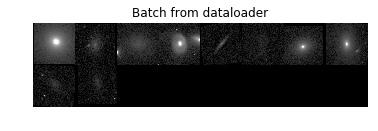

In [29]:
for i_batch, sample_batched in enumerate(train_dl):
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

De esat forma hemos aumentado nuestro dataset y probaremos con una nueva red...

In [30]:
class Net_end(nn.Module):
    def __init__(self):
        super(Net_end, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 6)
        self.fc1 = nn.Linear(16 * 60 * 60, 100)
        self.fc2 = nn.Linear(100, 60)
        self.fc3 = nn.Linear(60, 3)

    def forward(self, x):
        x = x.view(-1, 1, 255, 255)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 60 * 60)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [31]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(epoch, model, device, test_loader, best_accuracy, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if best_accuracy <= correct:
        best_accuracy = correct
        best_epoch = epoch
        print('This is the best test accuracy to date.')
    print('The corresonding test accuracy : {}/{}'.format(correct, 
        len(test_loader.dataset)))
    
    return best_accuracy, best_epoch

def validation(model, device, validation_loader, best_acc):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    if best_acc <= correct:
        best_acc = correct
    validation_loss /= len(validation_loader.dataset)
    print('The corresonding validation accuracy : {}/{}'.format(correct, 
        len(validation_loader.dataset)))
    return best_acc

def fit(model, params_net, epochs, schedule = False):
    optimizer = optim.SGD(model.parameters(), **params_net)
    best_accuracy = 0
    best_acc = 0
    best_epoch = 0
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    for epoch in range(1, epochs + 1):
        if schedule:
            scheduler.step()
        train(50, model, device, train_dl, optimizer, epoch)
        best_accuracy, best_epoch = test(epoch, model, device, 
                                         test_dl, best_accuracy, best_epoch)
        best_acc = validation(model,  device, validation_dl, best_acc)
        
        print('\n')
        
    print("Finished training network.")
    print("Corresponding test accuracy of {}/{} obtained in epoch {}".format(best_accuracy, 
                                                            len(test_dl.dataset), best_epoch))
    print("Corresponding validation accuracy of {}/{}.".format(best_acc, 
                                                            len(validation_dl.dataset)))

In [32]:
params_net = {'lr':0.01, 'momentum':0.1}
fit(Net_end().to(device), params_net, 60)

Train Epoch: 1 [0/1200 (0%)]	Loss: -0.333924
Train Epoch: 1 [500/1200 (42%)]	Loss: -0.332459
Train Epoch: 1 [1000/1200 (83%)]	Loss: -0.334818
This is the best test accuracy to date.
The corresonding test accuracy : 38/100
The corresonding validation accuracy : 25/100


Train Epoch: 2 [0/1200 (0%)]	Loss: -0.333835
Train Epoch: 2 [500/1200 (42%)]	Loss: -0.337237
Train Epoch: 2 [1000/1200 (83%)]	Loss: -0.334251
This is the best test accuracy to date.
The corresonding test accuracy : 38/100
The corresonding validation accuracy : 25/100


Train Epoch: 3 [0/1200 (0%)]	Loss: -0.339001
Train Epoch: 3 [500/1200 (42%)]	Loss: -0.334863
Train Epoch: 3 [1000/1200 (83%)]	Loss: -0.334923
This is the best test accuracy to date.
The corresonding test accuracy : 38/100
The corresonding validation accuracy : 25/100


Train Epoch: 4 [0/1200 (0%)]	Loss: -0.342108
Train Epoch: 4 [500/1200 (42%)]	Loss: -0.332740
Train Epoch: 4 [1000/1200 (83%)]	Loss: -0.339207
This is the best test accuracy to date.
The corr

Train Epoch: 34 [0/1200 (0%)]	Loss: -0.655153
Train Epoch: 34 [500/1200 (42%)]	Loss: -0.699993
Train Epoch: 34 [1000/1200 (83%)]	Loss: -0.699980
The corresonding test accuracy : 71/100
The corresonding validation accuracy : 67/100


Train Epoch: 35 [0/1200 (0%)]	Loss: -0.886640
Train Epoch: 35 [500/1200 (42%)]	Loss: -0.602681
Train Epoch: 35 [1000/1200 (83%)]	Loss: -0.700001
The corresonding test accuracy : 66/100
The corresonding validation accuracy : 47/100


Train Epoch: 36 [0/1200 (0%)]	Loss: -0.400000
Train Epoch: 36 [500/1200 (42%)]	Loss: -0.901402
Train Epoch: 36 [1000/1200 (83%)]	Loss: -0.644333
The corresonding test accuracy : 75/100
The corresonding validation accuracy : 61/100


Train Epoch: 37 [0/1200 (0%)]	Loss: -0.734326
Train Epoch: 37 [500/1200 (42%)]	Loss: -0.611235
Train Epoch: 37 [1000/1200 (83%)]	Loss: -0.799707
This is the best test accuracy to date.
The corresonding test accuracy : 81/100
The corresonding validation accuracy : 67/100


Train Epoch: 38 [0/1200 (0%)